# NLP

In [53]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import re

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [54]:
df_copom = pd.read_csv('df_copom_label_en.csv')

In [55]:
df_copom.head(1)

,Unnamed: 0,meeting_number,date_x,date_y,selic,decision,decision_txt,type,text,num_words,text_raw,num_words_raw,label_hawk_dove,label_next_meet
0,0,117,2006/03/08,2006/03/08,16.5,-0.75,decrease,statement,"march meeting , banco central brasil 's moneta...",55.0,"In the March Meeting, the Banco Central do Br...",67.0,dovish,decrease


In [56]:
df_ = df_copom[(df_copom['type'] == 'statement')]

In [57]:
df_.shape

(140, 14)

In [58]:
def count_words_ponct(text):
    return len(re.findall(r'[^\w\s]|\w+', text))

In [59]:
df_.loc[100,('num_words')]

528.0

In [60]:
count_words_ponct(df_.loc[100,('text')])

610

In [61]:
df_['text']

0      march meeting , banco central brasil 's moneta...
1      april meeting , monetary policy committee ( co...
2      may meeting , monetary policy committee ( copo...
3      july meeting , copom unanimously decided reduc...
4      august meeting , copom unanimously decided red...
                             ...                        
154    250th meeting , copom decided maintain selic r...
155    251st meeting , copom decided maintain selic r...
158    252nd meeting , copom decided maintain selic r...
160    since previous meeting monetary policy committ...
162    global environment remains challenging . episo...
Name: text, Length: 140, dtype: object

In [62]:
df_['num_words_ponct'] = df_['text'].apply(count_words_ponct)

C:\Users\ftrav\AppData\Local\Temp\ipykernel_27004\2047394345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['num_words_ponct'] = df_['text'].apply(count_words_ponct)


In [63]:
df_['num_words_ponct']

0       58
1       37
2       37
3       32
4       38
      ... 
154    565
155    581
158    541
160    494
162    474
Name: num_words_ponct, Length: 140, dtype: int64

In [64]:
df_['num_words_ponct'].unique()

array([ 58,  37,  32,  38,  33,  52,  80,  35,  56,  69,  68,  41,  39,
        54,  55,  64,  42,  50,  74,  81,  72,  27,  79,  66,  85,  90,
        65,  45,  46,  59,  96,  34,  88, 234,  57,  47,  73, 121, 125,
       154,  61,  48, 162,  53,  36,  60,  40, 113, 123, 122, 256, 440,
       521, 444, 477, 385, 438, 384, 398, 475, 466, 499, 463, 458, 531,
       610, 616, 565, 618, 518, 530, 538, 557, 501, 515, 546, 579, 536,
       485, 508, 609, 578, 602, 663, 657, 715, 576, 664, 552, 612, 240,
       667, 511, 527, 525, 623, 690, 550, 581, 541, 494, 474], dtype=int64)

In [13]:
df_ = df_[(df_['num_words_ponct'] <= 510)].copy()

In [65]:
df_.shape

(140, 15)

<Axes: >

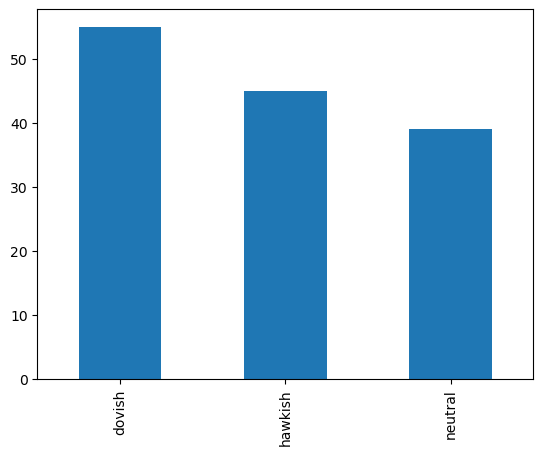

In [66]:
df_['label_hawk_dove'].value_counts().plot(kind='bar')

In [67]:
df_['label_hawk_dove']

0       dovish
1       dovish
2       dovish
3       dovish
4       dovish
        ...   
154    neutral
155    neutral
158    neutral
160    neutral
162        NaN
Name: label_hawk_dove, Length: 140, dtype: object

In [68]:
target_map = {'dovish': 0, 'hawkish': 1, 'neutral': 2}
df_['target'] = df_['label_hawk_dove'].map(target_map)

C:\Users\ftrav\AppData\Local\Temp\ipykernel_27004\1136188436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['target'] = df_['label_hawk_dove'].map(target_map)


In [69]:
df_ = df_[df_['target'].notna()]

In [70]:
df_['target'] = df_['target'].astype(int)

In [71]:
df_['target'].unique()

array([0, 1, 2])

In [72]:
df = df_[['text', 'target']]
df.columns = ['sentence', 'label']

In [73]:
df.head()

,sentence,label
0,"march meeting , banco central brasil 's moneta...",0
1,"april meeting , monetary policy committee ( co...",0
2,"may meeting , monetary policy committee ( copo...",0
3,"july meeting , copom unanimously decided reduc...",0
4,"august meeting , copom unanimously decided red...",0


In [74]:
df.to_csv('data_copom_transf_en.csv', index=None)

#### Convert to dataset

In [75]:
from datasets import load_dataset

raw_dataset = load_dataset('csv', data_files='data_copom_transf_en.csv')

Extracting data files: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.90it/s]


Dataset csv downloaded and prepared to C:/Users/ftrav/.cache/huggingface/datasets/csv/default-ae89f609a7c177ec/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.01it/s]


In [76]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 139
    })
})

#### Split test and train

In [77]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=2015)

In [78]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 97
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 42
    })
})

## Model

In [79]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# tokenizer = AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa")

# model = AutoModelForSequenceClassification.from_pretrained("gtfintechlab/FOMC-RoBERTa")

@article{shah2023trillion, 
  title={Trillion Dollar Words: A New Financial Dataset, Task & Market Analysis},
  author={Shah, Agam and Paturi, Suvan and Chava, Sudheer},
  journal={Available at SSRN 4447632},
  year={2023}
}

https://huggingface.co/gtfintechlab/FOMC-RoBERTa?text=Such+a+directive+would+imply+that+any+tightening+should+be+implemented+promptly+if+developments+were+perceived+as+pointing+to+rising+inflation.

In [80]:
checkpoint = 'gtfintechlab/FOMC-RoBERTa'

#### Tokenizer

In [81]:
from transformers import AutoTokenizer

In [98]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint, do_lower_case=True, truncation='longest_first') #, do_basic_tokenize=True)

In [114]:
# truncation="only_first" ensure that the beginning of the sentence is preserved
# "only_second" keeps the end of the text
# "longest_first" preserves as much text as possible from both ends

def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation='longest_first') 

In [115]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

#### Training

In [111]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [86]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

In [87]:
from torchinfo import summary

In [88]:
summary(model)

Layer (type:depth-idx)                                       Param #
RobertaForSequenceClassification                             --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   51,471,360
│    │    └─Embedding: 3-2                                   526,336
│    │    └─Embedding: 3-3                                   1,024
│    │    └─LayerNorm: 3-4                                   2,048
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  302,309,376
├─RobertaClassificationHead: 1-2                             --
│    └─Linear: 2-3                                           1,049,600
│    └─Dropout: 2-4                                          --
│    └─Linear: 2-5                                           3,0

In [89]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': acc, 'f1': f1}

In [90]:
training_args = TrainingArguments(
    output_dir='training_dir/en',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64
)

In [91]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [92]:
trainer.train()

C:\Users\ftrav\anaconda3\envs\tcc_gpu2\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.984999,0.547619,0.546129
2,No log,1.101017,0.761905,0.760439
3,No log,0.945483,0.809524,0.806915


TrainOutput(global_step=21, training_loss=1.0331297374906994, metrics={'train_runtime': 1399.1514, 'train_samples_per_second': 0.208, 'train_steps_per_second': 0.015, 'total_flos': 269547496156272.0, 'train_loss': 1.0331297374906994, 'epoch': 3.0})

In [93]:
!dir training_dir\en

 Volume in drive C has no label.
 Volume Serial Number is 5AAA-7C2A

 Directory of C:\Users\ftrav\Documents\Insper_tcc\training_dir\en

07/02/2023  11:46 AM    <DIR>          .
07/01/2023  10:18 PM    <DIR>          ..
07/01/2023  10:25 PM    <DIR>          checkpoint-10
07/02/2023  11:38 AM    <DIR>          checkpoint-14
07/01/2023  10:29 PM    <DIR>          checkpoint-15
07/02/2023  11:46 AM    <DIR>          checkpoint-21
07/01/2023  10:22 PM    <DIR>          checkpoint-5
07/02/2023  11:19 AM    <DIR>          checkpoint-6
07/02/2023  11:30 AM    <DIR>          checkpoint-7
07/02/2023  11:22 AM    <DIR>          runs
               0 File(s)              0 bytes
              10 Dir(s)  66,278,060,032 bytes free


In [101]:
from transformers import pipeline, AutoConfig

In [102]:
config = AutoConfig.from_pretrained(checkpoint)

In [103]:
savedmodel = pipeline('text-classification',
                      model='training_dir/en/checkpoint-21/',
                      tokenizer=tokenizer, 
                      config=config,
                      device=0,
                      framework="pt")

In [104]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 42
})

In [110]:
count_words_ponct(split['test']['sentence'][2])

552

In [116]:
test_pred = savedmodel(split['test']['sentence'])

RuntimeError: The expanded size of the tensor (580) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 580].  Tensor sizes: [1, 514]

In [ ]:
test_pred

In [ ]:
split['test']['label']

In [ ]:
def get_label(d):
    return int(d['label'].split('_')[1])

test_pred = [get_label(d) for d in test_pred]

In [ ]:
print("acc:", accuracy_score(split['test']['label'], test_pred))

In [ ]:
print("f1:", f1_score(split['test']['label'], test_pred, average='macro'))

In [ ]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
    classes = ['dovish', 'neutral', 'hawkish']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

cm = confusion_matrix(split['test']['label'], test_pred, normalize='true')
plot_cm(cm)

## gtfintechlab/FOMC-RoBERTa

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

tokenizer = AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa", do_lower_case=True, do_basic_tokenize=True)
model = AutoModelForSequenceClassification.from_pretrained("gtfintechlab/FOMC-RoBERTa", num_labels=3)
config = AutoConfig.from_pretrained("gtfintechlab/FOMC-RoBERTa")

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, config=config, device=0, framework="pt")

In [ ]:
results = classifier(["Such a directive would imply that any tightening should be implemented promptly if developments were perceived as pointing to rising inflation.", 
                      "The International Monetary Fund projects that global economic growth in 2019 will be the slowest since the financial crisis."], 
                      batch_size=128, truncation="only_first")

print(results)